Импортируем все необходимые библиотеки, затем считываем файлы. Спарсим даты из столбцов с датами из датафрейма orders, чтобы упростить дальнейшую работу.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv', sep=',')
order_items = pd.read_csv('olist_order_items_dataset.csv', sep=',')
orders = pd.read_csv('olist_orders_dataset.csv', sep=',', parse_dates=[3, 4, 5, 6, 7])

ЗАДАНИЕ 1

Я полагаю, что покупкой можно считать все заказы со статусом delivered, т.к. заказ мог быть оплачен, но потом отменён.
Для начала мёрджим датафреймы customers и orders. Отсеиваем все успешно доставленные заказы.

In [3]:
customers_orders_merged = customers.merge(orders, how='left')

Считаем кол-во повторений уникальных id клиентов.

In [4]:
uniq_customers = customers_orders_merged.query('order_status == "delivered"').customer_unique_id.value_counts() \
                                        .reset_index() \
                                        .rename(columns={'index': 'customer_id', 'customer_unique_id':'amount_of_orders'})

Отсеиваем только те customer_unique_id, которые встречались один раз.

In [5]:
uniq_customers.query('amount_of_orders==1')

,customer_id,amount_of_orders
2801,050e851d9dc8fee1217f1a61ef82d095,1
2802,38d92612568ca6e3d6b478e5fb004a6f,1
2803,35a412904ddbb1be0734bfe8dc2c6796,1
2804,d2f28957708c477204aaddbad2f2c37c,1
2805,36b6bda8a3ca33a3df452dd5c13fdfcd,1
...,...,...
93353,182e92ace06fb8e0107a4ebfffc01611,1
93354,2ec5e93fe922b65036198423712d6867,1
93355,428f4721a509be8c52de6ec2900ba918,1
93356,049aed9afdafa108602fe27e43455f56,1


In [6]:
undelivrd_orders = orders.query('order_status!="delivered"')

Не у всех заказов есть дата и время платежа, так что возьмём за точку отсчёта дату и время создания заказа.

Теперь выводим колонку с месяцем и годом создания заказа.

In [7]:
undelivrd_orders['month'] = undelivrd_orders['order_purchase_timestamp'].dt.month
undelivrd_orders['year'] = undelivrd_orders['order_purchase_timestamp'].dt.year

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


По сути дела, наши таблицы - это срез данных в определённый момент времени.
Следовательно, заказы со всеми статусами, кроме canceled и unavailable, ещё могут перейти в разряд заказов delivered.
Поэтому, строго говоря, в моменте недоставленные заказы - это только canceled + unavailable.

Сначала считаем общее кол-во недоставленных заказов, потом считаем их среднее кол-во в месяц и для удобства визуализируем.

In [8]:
orders_unavail_canceled = undelivrd_orders.query('order_status == "unavailable" | order_status =="canceled"') \
                        .groupby(['month', 'year', 'order_status'], as_index=False) \
                        .agg({'order_id': 'count'})

In [9]:
orders_unavail_canceled.groupby('order_status').order_id.mean().round(1)

order_status
canceled       26.0
unavailable    29.0
Name: order_id, dtype: float64

Text(0, 0.5, 'avg_orders')

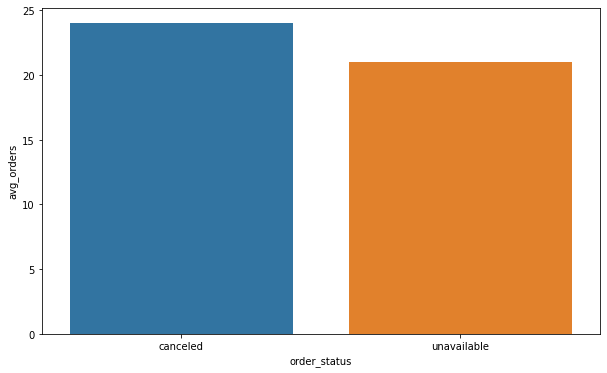

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=orders_unavail_canceled, x='order_status')
plt.ylabel('avg_orders')

ЗАДАНИЕ 3

Мёрджим датафреймы orders и order_items.

In [11]:
orders_and_products = order_items.merge(orders, how='left', on='order_id')

Добавляем колонку с наименованиями дней недели.

In [12]:
orders_and_products['weekday'] = orders_and_products['order_purchase_timestamp'].dt.day_name()

Здесь уже дата покупки = это дата оплаты. Выделяем их из датафрейма. Затем группируем и считаем уникальные значения product_id через столбец price

In [13]:
orders_and_products = orders_and_products.query('order_status == "delivered"') \
                   .groupby(['product_id', 'weekday']) \
                   .agg({'price':'count'}) \
                   .reset_index()

Делаем пивот, выводим самые популярные дни для каждого товара.

In [14]:
orders_and_products.pivot(index='product_id', columns='weekday', values='price') \
                     .idxmax(axis=1) \
                     .to_frame() \
                     .reset_index() \
                     .rename(columns={0: 'most_productive_day'})

,product_id,most_productive_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32211,fff6177642830a9a94a0f2cba5e476d1,Saturday
32212,fff81cc3158d2725c0655ab9ba0f712c,Monday
32213,fff9553ac224cec9d15d49f5a263411f,Friday
32214,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


ЗАДАНИЕ 4

У нас уже есть смёрдженный датафрейм, состоящий из датафреймов customers и orders.
Отсеиваем все успешно доставленные заказы.

In [15]:
avg_purch = customers_orders_merged.query('order_status == "delivered"')

Для удобства оставим только самые необходимые столбцы.

In [16]:
avg_purch = avg_purch[['customer_id', 'customer_unique_id', 'order_id', 'order_delivered_customer_date']]

Сначала считаем кол-во заказов на уникального пользователя помесячно.

In [17]:
avg_purch_ord = avg_purch.groupby(['order_delivered_customer_date', 'customer_unique_id'], as_index=False) \
                          .agg({'order_id': 'count'}) \
                          .rename(columns={'order_id': 'orders_by_month'})

Теперь выведем столбец, где посчитаем количество недель в каждом месяце.

In [18]:
avg_purch_ord['weeks'] = (avg_purch_ord['order_delivered_customer_date'].dt.daysinmonth) / 7
avg_purch_ord.head()

,order_delivered_customer_date,customer_unique_id,orders_by_month,weeks
0,2016-10-11 13:46:32,f176923a0a4ab546c7287791ccb82193,1,4.428571
1,2016-10-11 14:46:49,1dc848c11c2985635c268ff3dea707eb,1,4.428571
2,2016-10-13 03:10:34,f99053da7416fd6d626451cd49e44e0f,1,4.428571
3,2016-10-13 07:45:48,acf599349b44e4e51d2beacb549313ad,1,4.428571
4,2016-10-13 15:44:27,664f7107c351f24b16b68919398730a0,1,4.428571


Теперь считаем среднее кол-во заказов на пользователя в неделю.
Для наглядности оставим только id клиента и среднее кол-во заказов на каждого клиента в неделю.
Округлим до приемлемого числа знаков после запятой.

In [19]:
avg_purch_ord['orders_by_week'] = round(avg_purch_ord.orders_by_month / avg_purch_ord.weeks, 2)

In [20]:
avg_purch_ord[['customer_unique_id', 'orders_by_week']]

,customer_unique_id,orders_by_week
0,f176923a0a4ab546c7287791ccb82193,0.23
1,1dc848c11c2985635c268ff3dea707eb,0.23
2,f99053da7416fd6d626451cd49e44e0f,0.23
3,acf599349b44e4e51d2beacb549313ad,0.23
4,664f7107c351f24b16b68919398730a0,0.23
...,...,...
96461,c9f2b70eaddf459267a9de373aaf743b,0.23
96462,3ae68a873484afec224de126a94c5974,0.23
96463,4bc530761c1b59d33d7c6cb640d3ee78,0.23
96464,232422c2db1f7c69daf3b0f0421ebb43,0.23
